In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

In [244]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [245]:
df = pd.read_csv('credit_card_default_analysis.csv')

In [246]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Размер кредитного лимита (LIMIT_BAL)

Построим 2 выборки: для тех, кто вернул кредит и для тех, кто не вернул.

In [485]:
# LIMIT_BAL 
lim0 = df[df.default == 0].LIMIT_BAL
lim1 = df[df.default == 1].LIMIT_BAL

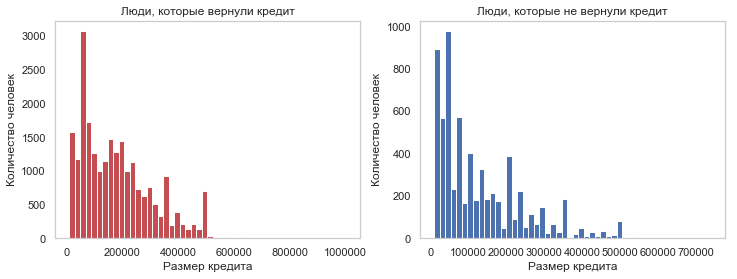

In [489]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(lim0, color = 'r', bins = 50)
pylab.xlabel(u'Размер кредита')
pylab.ylabel(u'Количество человек')
pylab.title(u'Люди, которые вернули кредит')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(lim1, color = 'b', bins = 50)
pylab.xlabel(u'Размер кредита')
pylab.ylabel(u'Количество человек')
pylab.title(u'Люди, которые не вернули кредит')

pylab.show()

Распределения явно не нормальные. По графикам тяжело явно сказать равны ли средние.

### Равны ли медианные значения кредитного лимита для тех, кто вернул его и для тех, кто не вернул.

Построим 95% доверительный интервал для разности медиан и проверим, входит ли туда 0.
Для этого используем бутстреп, так как он не делает предположений о распределении.

In [70]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [71]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [81]:
np.random.seed(0)

lim0_median_scores = map(np.median, get_bootstrap_samples(lim0.values, 1000))
lim1_median_scores = map(np.median, get_bootstrap_samples(lim1.values, 1000))

print "95% confidence interval for the lim0 median:",  stat_intervals(lim0_median_scores, 0.05)
print "95% confidence interval for the lim1 median:",  stat_intervals(lim1_median_scores , 0.05)

95% confidence interval for the lim0 median: [150000. 150000.]
95% confidence interval for the lim1 median: [80000. 90000.]


In [84]:
lim_median_scores = map(lambda x: x[1] - x[0], zip(lim1_median_scores, lim0_median_scores))

In [85]:
print "95% confidence interval for the difference between lim1 and lim",  stat_intervals(lim_median_scores, 0.05)

95% confidence interval for the difference between lim1 and lim [60000. 70000.]


95% доверительный интервал для тех, кто вернул кредит [150000. 150000.]

95% доверительный интервал для тех, кто не вернул кредит [80000. 90000.]

95% доверительный интервал для разности [60000. 70000.]. 

Вывод: В интервал не входит 0, соответственно  отвергаем гипотезу о том, что медианные значения кредитного лимита равны для тех, кто вернул его и для тех, кто не вернул.

### Проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Имеем 2 несвязанные выборки.

Проверим выборки на нормальность с  помощью Критерий Шапиро-Уилка

 $H_0\colon$ размер кредитного лимита распредлены нормально
 
 $H_1\colon$ не нормально.

In [19]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(lim0)
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(lim1)

Shapiro-Wilk normality test, W-statistic: 0.919726, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.854983, p-value: 0.000000


/Users/andreyleonov/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/andreyleonov/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Так как p-value < 0, то мы отвергаем нулевую гипотезу. Выборки распределены ненормально, поэтому мы не можем применять критерий Стьюдента.

### Проверим с помощью перестановочный критерия

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [187]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [189]:
print "p-value: %f" % permutation_test(lim0, lim1, max_permutations = 5000)

p-value: 0.000200


Вывод: pvalue < 0.05, соотвественно отвергается гипотеза о том, что распределения равны и средние равны.
Полученные результаты значимы с практической точки зрения.

## Пол (SEX)

Построим 2 выборки: для тех, кто вернул кредит и для тех, кто не вернул.

In [54]:
sex0 = df[df.default == 0].SEX
sex1 = df[df.default == 1].SEX

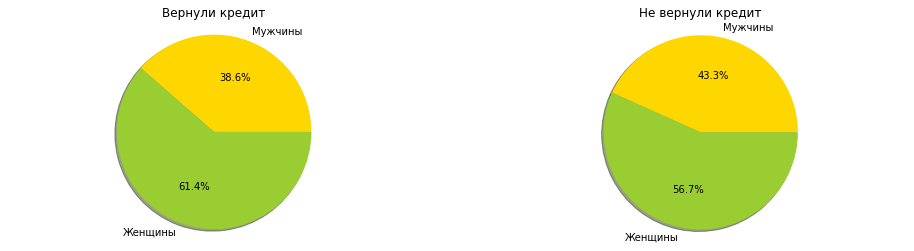

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2)
# вернули кредит
labels1 = u'Мужчины', u'Женщины'
sizes1 = [len(sex0[sex0 == 1]), len(sex0[sex0 == 2])]
colors1 = ['gold', 'yellowgreen']
 
# не вернули кредит
labels2 = u'Мужчины', u'Женщины'
sizes2 = [len(sex1[sex1 == 1]), len(sex1[sex1 == 2])]
colors2 = ['gold', 'yellowgreen']
 
# Plot1 
ax1.pie(sizes1, labels=labels1, colors=colors1,
autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
ax1.set_title(u'Вернули кредит')

# Plot2 
ax2.pie(sizes2, labels=labels2, colors=colors2,
autopct='%1.1f%%', shadow=True)
ax2.axis('equal')
ax2.set_title(u'Не вернули кредит')

plt.show()


По графику видно что в распределениях пропорции между мужчинами и женщинами отличаются.

###  Проверим с помощью доверительного интервала что гендерный состав группы людей вернувших и не вернувших кредит отличается

Построим интервальные оценки долей

In [165]:
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [169]:
sex0_proportion = proportion_confint(len(sex0[sex0 == 1]), 
                                            len(sex0),
                                            method = 'wilson')
sex1_proportion = proportion_confint(len(sex1[sex1 == 1]), 
                                            len(sex1),
                                            method = 'wilson')

In [171]:
print 'interval for sex0 [%f, %f]' % sex0_proportion
print 'interval for sex1 [%f, %f]' % sex1_proportion

interval for sex0 [0.379627, 0.392110]
interval for sex1 [0.421062, 0.444898]


Построим 95% доверительный интервал для  2 долей и посмотрим входит ли туда 0.

In [160]:
a = len(sex0[sex0 == 1])
b = len(sex1[sex1 == 1])

In [161]:
def proportions_confint_diff_ind(sample1, sample2, a, b, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(a) / len(sample1)
    p2 = float(b) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [173]:
print "confidence interval: [%f, %f]" % proportions_confint_diff_ind(sex0.values, sex1.values, a, b)

confidence interval: [-0.060548, -0.033635]


95% доверительный интервал для тех, кто вернул кредит [0.379627, 0.392110]

95% доверительный интервал для тех, кто не вернул кредит [0.421062, 0.444898]

95% доверительный интервал для разности [-0.060548, -0.033635]. 

Вывод: так как 95% доверительные интервалы для клиентов, которые вернули и не вернули не пересекаются, и так 95% интервал для разности долей не содержит 0, то следовательно гендерный состав группы людей вернувших и не вернувших кредит отличается.  

###  Проверим с помощью статистического критерия что гендерный состав группы людей вернувших и не вернувших кредит отличается

Применим Z-критерий для доли для двух несвязанных выборок:

 $H_0\colon$ p1 = p2
 
 $H_1\colon$ p1 $\neq$ p2.

In [177]:
a = len(sex0[sex0 == 1])
b = len(sex1[sex1 == 1])

In [179]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(a) / n1
    p2 = float(b) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [180]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [184]:
print "p-value:" + str(proportions_diff_z_test(proportions_diff_z_stat_ind(sex0.values, sex1.values)))

p-value:4.472866521609831e-12


Вывод: p-value < 0.05. Нулевая гипотеза отвергается, следовательно  гендерный состав группы людей вернувших и не вернувших кредит отличается. Полученный результат не значим с практической точки зрения, так как доверительный интервал для разности [-0.060548, -0.033635] очень мал.

# Образование (EDUCATION)

In [199]:
education0 = df[df.default == 0].EDUCATION
education1 = df[df.default == 1].EDUCATION

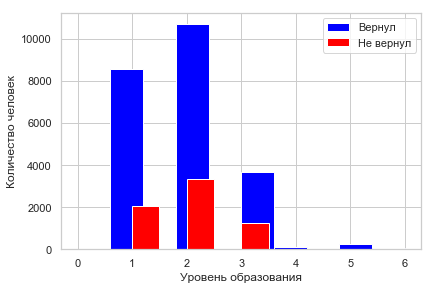

In [350]:
plt.hist(education0, color = 'blue',  label=u'Вернул')
plt.hist(education1, color = 'red', label=u'Не вернул')
plt.legend()
plt.tight_layout() 
plt.xlabel(u'Уровень образования')
plt.ylabel(u'Количество человек')
plt.show()

In [352]:
df[df.EDUCATION == int(0)].default

3769     0
5945     0
6876     0
14631    0
15107    0
16881    0
16896    0
17414    0
19920    0
20030    0
23234    0
24137    0
27155    0
27270    0
Name: default, dtype: int64

По графику видно, что у докторов нет просрочек по кредитам.

### Таблица сопряженности

Построим таблицу сопряженности.

In [265]:
observed = pd.crosstab(df.EDUCATION, df.default)

In [445]:
observed

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


Посчитаем ожидаемое количество человек

In [ ]:
from scipy.stats.contingency import expected_freq

In [449]:
expected = pd.DataFrame(expected_freq(observed))
expected

,0,1
0,10.9032,3.0968
1,8243.5980,2341.4020
2,10926.5640,3103.4360
3,3829.3596,1087.6404
4,95.7924,27.2076
5,218.0640,61.9360
6,39.7188,11.2812


In [450]:
df1 = observed - expected
df1

default,0,1
EDUCATION,,
0,3.0968,-3.0968
1,305.4020,-305.4020
2,-226.5640,226.5640
3,-149.3596,149.3596
4,20.2076,-20.2076
5,43.9360,-43.9360
6,3.2812,-3.2812


Отнормируем таблицу, используя min - max :

In [451]:
df_norm = (df1 - df1.mean()) / (df1.max() - df1.min())
df_norm

default,0,1
EDUCATION,,
0,0.005821,-0.005821
1,0.574101,-0.574101
2,-0.425899,0.425899
3,-0.280769,0.280769
4,0.037987,-0.037987
5,0.082592,-0.082592
6,0.006168,-0.006168


Text(0.5,1,u'\u0420\u0430\u0437\u043d\u0438\u0446\u044b \u0432 \u043e\u0436\u0438\u0434\u0430\u0435\u043c\u044b\u0445 \u0438 \u043d\u0430\u0431\u043b\u044e\u0434\u0430\u0435\u043c\u044b\u0445 \u0437\u043d\u0430\u0447\u0435\u043d\u0438\u044f\u0445 \u043a\u043e\u043b\u0438\u0447\u0435\u0441\u0442\u0432\u0430 \u0447\u0435\u043b\u043e\u0432\u0435\u043a \u0432\u0435\u0440\u043d\u0443\u0432\u0448\u0438\u0445 \u0438 \u043d\u0435 \u0432\u0435\u0440\u043d\u0443\u0432\u0448\u0438\u0445 \u0434\u043e\u043b\u0433')

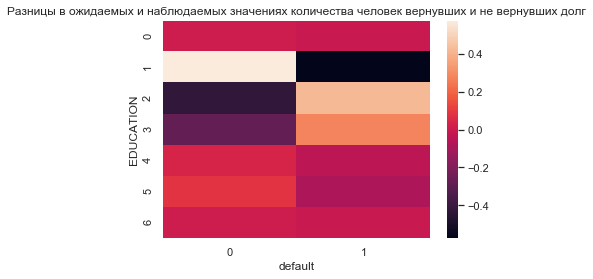

In [472]:
from seaborn import heatmap
heatmap(df_norm) 
plt.title(u'Разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг')

### Индикаторы

Построим доверительный интервал Уилсона:

In [500]:
from statsmodels.stats.proportion import proportion_confint

In [501]:
ls = []
for i in range(7):
    df1 = df[df.EDUCATION == int(i)].default
    ls.append(proportion_confint(sum(df1), len(df1), method = 'wilson'))
print ls

[(2.7755575615628914e-17, 0.21531080273763586), (0.1849512163529897, 0.19996732970999295), (0.23038098290588793, 0.24445988503282373), (0.2396447960904251, 0.2638953970972908), (0.02783797958312565, 0.11282154125946578), (0.041047153641855086, 0.09931803115612199), (0.08169223220048706, 0.2801044677298777)]


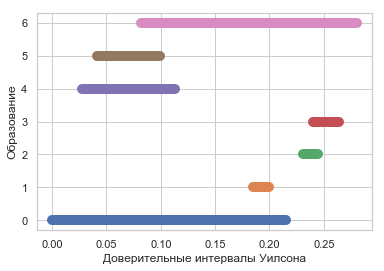

In [502]:
count = -1
for i in ls:
    count += 1
    plt.plot(i, (count,count), linewidth = 10)
plt.xlabel(u'Доверительные интервалы Уилсона')
plt.ylabel(u'Образование')
plt.show()

 Образование бакалавр (2) и выпускник школы (3) являются  наилучшим индикатором того что человек не отдаст долг.

### Гипотеза

Проверим гипотезу,  что о том, что образование не влияет на то, вернет ли человек долг.

$H_0\colon$ выборки для признаков EDUCATION и default независимы
 
 $H_1\colon$ $H_0\colon$ неверна

In [353]:
from scipy.stats import chi2_contingency

In [432]:
chi = chi2_contingency(observed, correction=False)

In [438]:
n = len(df)
shape = observed.shape
chi = chi2_contingency(observed, correction=False)
def v_cramer(chi, n, shape):
    return np.sqrt(chi[0]/n/(min(shape[0], shape[1])-1))
print "p-value: ", chi[1] 
print 'v_cramer: ', v_cramer(chi, n, shape)

p-value:  1.2332626245415605e-32
v_cramer:  0.07376009713252163


Выводы:
1. p-value < 0.05 и коэфициент v_cramer не равен 0, то соответсвенно  $H_0$ отвергается. Признаки EDUCATION и default зависимы, поэтому признак EDUCATION  практически является важным при рассмотрении заявки на кредит.
2. Способом наглядного изображения является heatmap.
3. Отнормируем используя min-max.
4. Образование доктора (0) является лучшим индикатором того, что человек отдаст долг. 
5. Образование бакалавр (2) и выпускник школы (3) являются  наилучшим индикатором того что человек не отдаст долг.

# Семейное положение (MARRIAGE)

In [453]:
marriage0 = df[df.default == 0].MARRIAGE
marriage1 = df[df.default == 1].MARRIAGE

Text(0.5,1,u'\u041a\u0440\u0435\u0434\u0438\u0442\u044b \u0441 \u043f\u0440\u043e\u0441\u0440\u043e\u0447\u043a\u0430\u043c\u0438, \u0432\u0437\u0430\u0432\u0438\u0441\u0438\u043c\u043e\u0441\u0442\u0438 \u043e\u0442 \u0441\u0435\u043c\u0435\u0439\u043d\u043e\u0433\u043e \u0441\u0442\u0430\u0442\u0443\u0441\u0430')

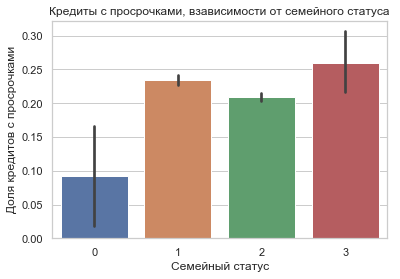

In [456]:
sns.barplot(df.MARRIAGE, df.default)
plt.ylabel(u'Доля кредитов с просрочками')
plt.xlabel(u'Семейный статус')
plt.title(u'Кредиты с просрочками, взависимости от семейного статуса')

Самая малая доля кредитов с просрочками у группы (0). У остальных групп примерно одинаковые доли.

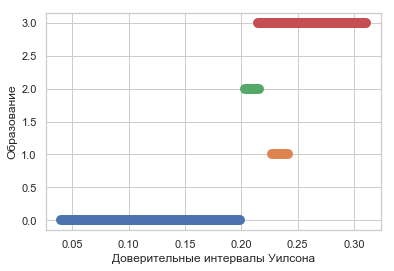

In [503]:
ls1 = []
for i in range(4):
    df2 = df[df.MARRIAGE == int(i)].default
    ls1.append(proportion_confint(sum(df2), len(df2), method = 'wilson'))

count = -1
for i in ls1:
    count += 1
    plt.plot(i, (count,count), linewidth = 10)
plt.xlabel(u'Доверительные интервалы Уилсона')
plt.ylabel(u'Образование')
plt.show()

Для групп 0 и 1 большие доверительные интервалы.

### Гипотеза

Проверим гипотезу,  что о том, что семейное положение не влияет на то, вернет ли человек долг.

$H_0\colon$ выборки для признаков MARRIAGE и default независимы
 
 $H_1\colon$ $H_0\colon$ неверна

In [476]:
observed_marriage = pd.crosstab(df.MARRIAGE, df.default)
observed_marriage

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


In [477]:
chi = chi2_contingency(observed, correction=False)
n = len(df)
shape = observed_marriage.shape
chi = chi2_contingency(observed_marriage, correction=False)
def v_cramer(chi, n, shape):
    return np.sqrt(chi[0]/n/(min(shape[0], shape[1])-1))
print "p-value: ", chi[1] 
print 'v_cramer: ', v_cramer(chi, n, shape)

p-value:  8.825862457577375e-08
v_cramer:  0.034478203662766466


Вывод: p-value < 0.05 и коэфициент v_cramer не равен 0, то соответсвенно  $H_0$ отвергается. Признаки EDUCATION и default зависимы, поэтому признак EDUCATION  практически является важным при рассмотрении заявки на кредит.

# Возраст (AGE)

Построим 2 выборки: для тех, кто вернул кредит и для тех, кто не вернул.

In [482]:
age0 = df[df.default == 0].AGE
age1 = df[df.default == 1].AGE

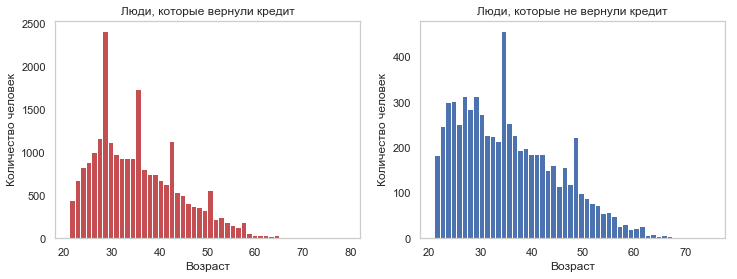

In [488]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(age0, color = 'r', bins = 50)
pylab.xlabel(u'Возраст')
pylab.ylabel(u'Количество человек')
pylab.title(u'Люди, которые вернули кредит')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(age1, color = 'b', bins = 50)
pylab.xlabel(u'Возраст')
pylab.ylabel(u'Количество человек')
pylab.title(u'Люди, которые не вернули кредит')

pylab.show()

Выборки явно распределены ненормально.

### Равны ли медианные значения возрастов для тех, кто вернул его и для тех, кто не вернул.


Построим 95% доверительный интервал для разности медиан и проверим, входит ли туда 0.
Для этого используем бутстреп, так как он не делает предположений о распределении.

In [494]:
np.random.seed(0)

age0_median_scores = map(np.median, get_bootstrap_samples(age0.values, 1000))
age1_median_scores = map(np.median, get_bootstrap_samples(age1.values, 1000))

a = len(age0[age0 == 1])
b = len(age1[age1 == 1])
age_median_scores = map(lambda x: x[1] - x[0], zip(age1_median_scores, age0_median_scores))

print "95% confidence interval for the lim0 median:",  stat_intervals(age0_median_scores, 0.05)
print "95% confidence interval for the lim1 median:",  stat_intervals(age1_median_scores , 0.05)
print "95% confidence interval for the difference between age0 and age",  stat_intervals(age_median_scores, 0.05)

95% confidence interval for the lim0 median: [34. 34.]
95% confidence interval for the lim1 median: [34. 35.]
95% confidence interval for the difference between age0 and age [-1.  0.]


Вывод: В интервал входит 0, соответственно  не можем однозначно сказать что есть разница в медианных значениях возрастов для тех, кто вернул его и для тех, кто не вернул.

### Проверим с помощью перестановочный критерия

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [497]:
print "p-value: %f" % permutation_test(age0, age1, max_permutations = 5000)

p-value: 0.018000


Вывод:
    1. Из-за того что p-value < 0.05, гипотеза о равенстве распределений отвергается.
    2. Из-за того что p < 0.05 но доверительный интервал содержит 0, мы не можем однозначно интерпретирвать эти данные и определить значимы ли полученные результаты с практической точки зрения. 